In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from keras.applications.vgg16 import preprocess_input, VGG16
import tensorflow as tf
import keras

from utils.dataset import OCRDataset
from models.east import EAST
from models.generator import DataGenerator

Using TensorFlow backend.


Graph Visualization
---


In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

Data Pipeline
----


In [3]:
# Dataset 가져오기
train_set = OCRDataset(data_type='train')
test_set = OCRDataset(data_type='test')

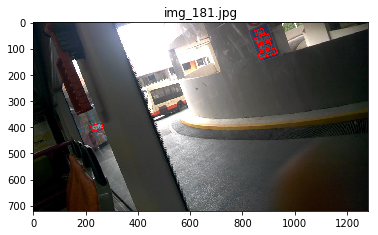

In [4]:
filename = train_set.filenames[92]
plt.title(filename)
plt.imshow(train_set.show_image(filename))
plt.show()

In [15]:
train_gen = DataGenerator(train_set)

In [16]:
images, (train_scores, train_geos) = train_gen[0]

Model Test Training
---

#### Objective
모델이 정상적으로 구현되어 있는지를 평가하기 위해 크게 3단계로 진행해 보고자 합니다.

### (1) 1개 배치가 학습되는지 확인

In [13]:
# declare model class
east = EAST()

# Build Model 
# 순서대로 쌓아올립니다.
(east
 ._attach_stem_network()
 ._attach_branch_network(num_layers=(128, 64, 32, 32))
 ._attach_output_network()
 ._attach_loss_network()
 ._attach_optimizer()
)

# initialize the uninitialized variables
# -> stem network는 pretrained model을 이용하기 때문에
# 모두 초기화하는 경우, pretrained model을 이용한 것이 무의미해짐
east.initialize_variables()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [14]:
headtune_op, finetune_op = east.graph.get_collection(tf.GraphKeys.TRAIN_OP)
loss, score_loss, geo_loss, area_loss, angle_loss = east.graph.get_collection(tf.GraphKeys.LOSSES)
y_true_cls, y_true_geo, lr, x = east.graph.get_collection('inputs')

In [ ]:
for i in range(100):
    result = east._session.run([headtune_op,
                       loss, 
                       score_loss, 
                       geo_loss, 
                       area_loss, 
                       angle_loss
                      ],feed_dict={
        x: images,
        y_true_cls: train_scores,
        y_true_geo: train_geos
    })
    
    print(f"{i} : Loss :{result[1]:.3f} score :{result[2]:.3f} geo :{result[3]:.3f} area_loss :{result[4]:.3f} angle_loss :{result[5]:.3f}")

0 : Loss :3.901 score :0.074 geo :3.828 area_loss :2.918 angle_loss :0.091
1 : Loss :3.632 score :0.082 geo :3.549 area_loss :2.698 angle_loss :0.085
2 : Loss :3.353 score :0.089 geo :3.264 area_loss :2.518 angle_loss :0.075
3 : Loss :3.166 score :0.092 geo :3.074 area_loss :2.381 angle_loss :0.069
4 : Loss :3.027 score :0.089 geo :2.937 area_loss :2.259 angle_loss :0.068
5 : Loss :2.841 score :0.082 geo :2.760 area_loss :2.142 angle_loss :0.062
6 : Loss :2.654 score :0.072 geo :2.582 area_loss :2.046 angle_loss :0.054
7 : Loss :2.534 score :0.061 geo :2.472 area_loss :1.971 angle_loss :0.050
8 : Loss :2.436 score :0.052 geo :2.383 area_loss :1.901 angle_loss :0.048
9 : Loss :2.310 score :0.046 geo :2.264 area_loss :1.820 angle_loss :0.044
10 : Loss :2.184 score :0.042 geo :2.142 area_loss :1.733 angle_loss :0.041


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/17

---